In [55]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import time
import itertools
import statsmodels.api as sm
import numpy.ma as ma
from scipy.stats.stats import pearsonr, normaltest
from scipy.spatial.distance import correlation
from sklearn.model_selection import train_test_split
os.getcwd()
os.chdir(r'C:\Users\Haneef Usmani\Desktop\STAT 303-2\Project')

In [110]:
flight = pd.read_csv('flights_clean.csv').dropna()

In [77]:
flight.columns

Index(['airline', 'day', 'day_of_week', 'departure_delay',
       'destination_airport', 'destination_latitude', 'destination_longitude',
       'distance', 'month', 'origin_airport', 'origin_latitude',
       'origin_longitude', 'scheduled_arrival', 'scheduled_departure',
       'scheduled_time', 'state_destination', 'state_origin', 'taxi_in',
       'taxi_out', 'day_of_year', 'origin_temperature',
       'destination_temperature'],
      dtype='object')

In [ ]:
model_all = smf.ols(formula='departure_delay ~ airline + day + day_of_week + destination_airport + destination_latitude + destination_longitude + distance + month + origin_airport + origin_latitude + origin_longitude + scheduled_arrival + scheduled_departure + scheduled_time + state_destination + state_origin + taxi_in + taxi_out + day_of_year + origin_temperature + destination_temperature', data=train).fit()
model_all.summary()

In [111]:
# split flight into train and test
train, test = train_test_split(flight, test_size=0.2)

In [119]:
# drop all categorical variables from train
train_drop = train.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [120]:
X = train[['airline', 'day', 'day_of_week', 'destination_airport', 'destination_latitude', 'destination_longitude', 'distance', 'month', 'origin_airport', 'origin_latitude', 'origin_longitude', 'scheduled_arrival', 'scheduled_departure', 'scheduled_time', 'state_destination', 'state_origin', 'taxi_in', 'taxi_out', 'day_of_year', 'origin_temperature', 'destination_temperature']]
# take out all categorical variables
X = X.drop(['airline', 'destination_airport', 'origin_airport', 'state_destination', 'state_origin'], axis=1)

In [121]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = smf.ols('(departure_delay)~' + '+'.join(predictor_subset),data = train_drop).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [122]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [123]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [124]:
models_best = forward_selection()

Processed  16 models on 1 predictors in 7.810021877288818 seconds.
Processed  15 models on 2 predictors in 9.418032884597778 seconds.
Processed  14 models on 3 predictors in 12.509913206100464 seconds.
Processed  13 models on 4 predictors in 15.887221336364746 seconds.
Processed  12 models on 5 predictors in 17.792967557907104 seconds.
Processed  11 models on 6 predictors in 19.648821353912354 seconds.
Processed  10 models on 7 predictors in 18.72304916381836 seconds.
Processed  9 models on 8 predictors in 14.879640340805054 seconds.
Processed  8 models on 9 predictors in 15.141238451004028 seconds.
Processed  7 models on 10 predictors in 15.55549669265747 seconds.
Processed  6 models on 11 predictors in 14.283883094787598 seconds.
Processed  5 models on 12 predictors in 13.366007566452026 seconds.
Processed  4 models on 13 predictors in 11.649682998657227 seconds.
Processed  3 models on 14 predictors in 9.742460489273071 seconds.
Processed  2 models on 15 predictors in 7.2355272769927

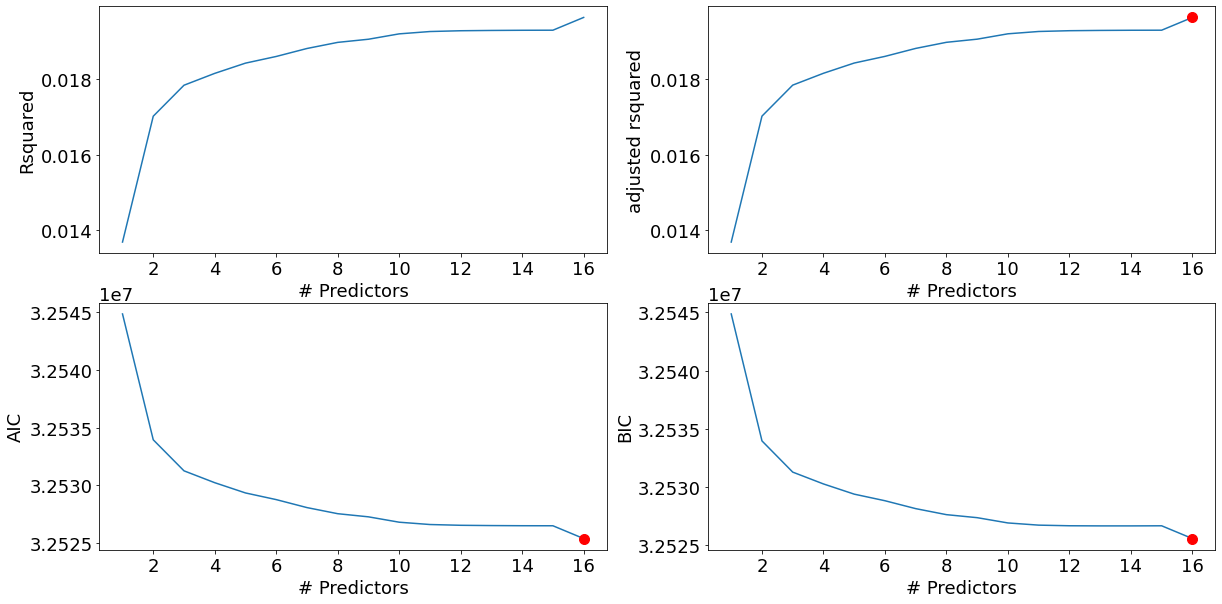

In [125]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [126]:
best_fwd_reg_model = models_best['model'][16]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        departure_delay   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4037.
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:26:42   Log-Likelihood:            -1.6263e+07
No. Observations:             3225535   AIC:                         3.253e+07
Df Residuals:                 3225518   BIC:                         3.253e+07
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -30.7032      1.041    -29.493      0.000     -32.744     -28.663
scheduled_departure         0.0120   9.77e-05    122.969      0.000       0.012       0.012
taxi_out                    0.2214      0.002     92.861      0.000       0.217       0.226
scheduled_arrival           0.0044   9.26e-05     47.976      0.000       0.004       0.005
day_of_week                -0.3479      0.010    -33.162      0.000      -0.368      -0.327
taxi_in                     0.0909      0.004     24.449      0.000       0.084       0.098
scheduled_time              0.0217      0.003      8.460      0.000       0.017       0.027
destination_longitude       0.0291      0.002     15.814      0.000       0.025       0.033
day_of_year                -1.1430      0.034    -33.542      0.000      -1.210      -1.076
origin_latitude            -0.1256      0.005    -25.246      0.000      -0.135      -0.116
origin_temperature         -0.0447      0.002    -22.306      0.000      -0.049      -0.041
origin_longitude            0.0087      0.002      3.872      0.000       0.004       0.013
destination_latitude       -0.0426      0.005     -8.559      0.000      -0.052      -0.033
distance                   -0.0016      0.000     -5.043      0.000      -0.002      -0.001
destination_temperature    -0.0058      0.002     -2.884      0.004      -0.010      -0.002
month                      34.7156      1.038     33.442      0.000      32.681      36.750
day                         1.1370      0.034     33.350      0.000       1.070       1.204
==============================================================================
Omnibus:                  4355595.520   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2064803870.582
Skew:                           7.523   Prob(JB):                         0.00
Kurtosis:                     126.033   Cond. No.                     1.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [127]:
pred_price = (best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.departure_delay)**2).mean())

37.252349402972115